# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Defining transforms
train_data = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download = True, train = True, transform = transforms.ToTensor())
train_images = torch.stack([image for image, _ in train_data], dim=3)
mean, std = train_images.view(3, -1).mean(dim=1), train_images.view(3, -1).std(dim=1)

train_transforms = transforms.Compose([transforms.RandomResizedCrop(32),
                                       transforms.RandomRotation(10),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandAugment(num_ops = 2, magnitude = 10,
                                                              interpolation = transforms.InterpolationMode.BILINEAR),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean, std)])

test_transforms = transforms.Compose([transforms.RandomResizedCrop(32),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)])

#Creating validation set
n_tot = len(train_data)
#Splitting 20% of training data for validation
split = int(np.floor(0.2 * n_tot))
shuffled_indices = torch.randperm(n_tot)
train_idx, valid_idx = shuffled_indices[split:], shuffled_indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Create training set and define train dataloader

train_data = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download = True, train = True, transform = train_transforms)
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 64, sampler = train_sampler)

# define validate dataloader
valid_data = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download = True, train = True, transform = test_transforms)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 64, sampler = valid_sampler)

# Create test set and define test dataloader
test_data = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download = True, train = False, transform = test_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = True)
# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 102788170.98it/s]


Extracting /home/student/.pytorch/CIFAR10_data/cifar-10-python.tar.gz to /home/student/.pytorch/CIFAR10_data/
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
%matplotlib inline
# helper function to un-normalize and display an image
def imshow(img, sub):
    img = img / 2 + 0.5  # unnormalize
    sub.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    sub.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

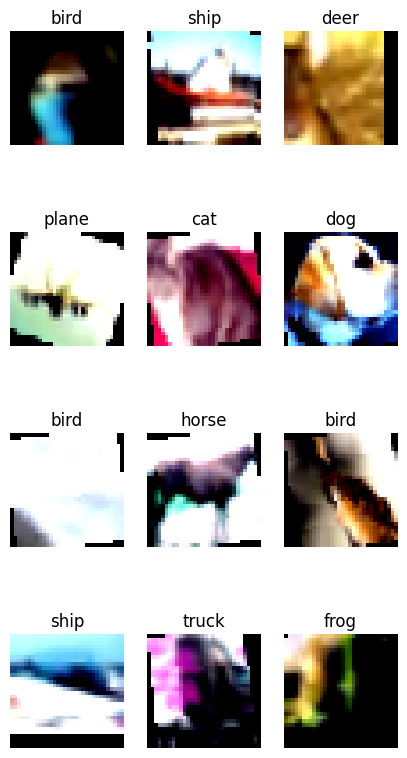

In [9]:
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
# display 12 images
fig, subs = plt.subplots(4, 3, figsize=(5, 10))
for i, sub in enumerate(subs.flatten()):
    imshow(images[i], sub)
    sub.set_title(classes[labels[i]])

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
                
            nn.Conv2d(32, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        
            nn.Conv2d(64, 128, 3, padding = 1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            
            nn.Linear(128 * 4 * 4, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(256, 10),
            nn.LogSoftmax(dim = 1)
        )
        
    def forward(self, x):
        return self.model(x)
    
model = Net()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [11]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
model.to(device)

Net(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=2048, out_features=1024, bias=True)
    (14): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, tra

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [12]:
epochs = 50
steps = 0
train_loss = 0
#validate_every = 250
training_losses, validate_losses, accuracies = [], [], []

for epoch in range(epochs):
    for images, labels in trainloader:
        steps += 1
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    else:
        valid_loss = 0
        accuracy = 0
        model.eval()
        with torch.no_grad():
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                output = model.forward(images)
                batch_loss = criterion(output, labels)
                    
                valid_loss += batch_loss.item()
                    
                #Calculate accuracy
                ps = torch.exp(output)
                top_p, top_class = ps.topk(1, dim = 1)                    
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
        print(f"Epoch {epoch + 1} / {epochs},    "
              f"Train loss: {train_loss / len(trainloader):.3f},    "
              f"Validation loss: {valid_loss / len(validloader):.3f},    "
              f"Validation accuracy: {accuracy / len(validloader):.3f}")
            
        training_losses.append(train_loss / len(trainloader))
        validate_losses.append(valid_loss / len(validloader)) 
        accuracies.append(accuracy / len(validloader))  
            
        train_loss = 0
        model.train()

Epoch 1 / 50,    Train loss: 1.921,    Validation loss: 1.639,    Validation accuracy: 0.390
Epoch 2 / 50,    Train loss: 1.722,    Validation loss: 1.490,    Validation accuracy: 0.462
Epoch 3 / 50,    Train loss: 1.622,    Validation loss: 1.366,    Validation accuracy: 0.511
Epoch 4 / 50,    Train loss: 1.551,    Validation loss: 1.338,    Validation accuracy: 0.522
Epoch 5 / 50,    Train loss: 1.490,    Validation loss: 1.268,    Validation accuracy: 0.549
Epoch 6 / 50,    Train loss: 1.450,    Validation loss: 1.235,    Validation accuracy: 0.563
Epoch 7 / 50,    Train loss: 1.424,    Validation loss: 1.167,    Validation accuracy: 0.581
Epoch 8 / 50,    Train loss: 1.389,    Validation loss: 1.148,    Validation accuracy: 0.591
Epoch 9 / 50,    Train loss: 1.372,    Validation loss: 1.142,    Validation accuracy: 0.599
Epoch 10 / 50,    Train loss: 1.338,    Validation loss: 1.116,    Validation accuracy: 0.607
Epoch 11 / 50,    Train loss: 1.320,    Validation loss: 1.121,    Va

Plot the training loss (and validation loss/accuracy, if recorded).

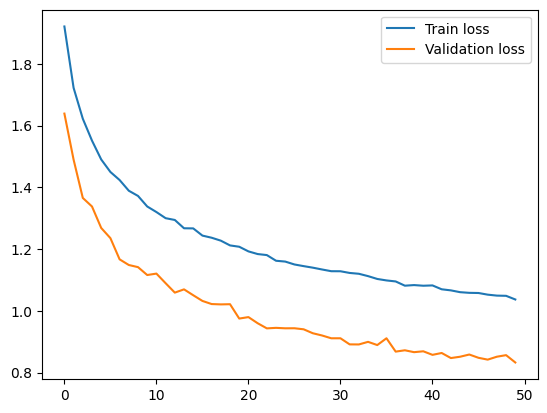

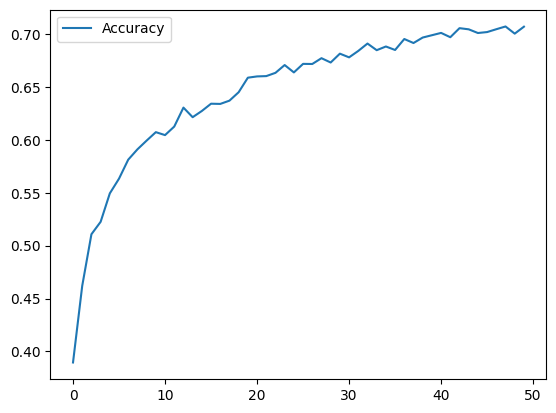

In [13]:
%matplotlib inline
%config inlineBackend.figure_format='retina'

plt.plot(training_losses, label='Train loss')
plt.plot(validate_losses, label='Validation loss')
plt.legend()
plt.show()
plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.show()


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [17]:
accuracy = 0
test_loss = 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        loss = criterion(output, labels)
                    
        test_loss += loss.item()
                    
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()     
                        
print(f"Test Accuracy: {accuracy / len(testloader) * 100}")

Test Accuracy: 71.29777070063695


## Saving your model
Using `torch.save`, save your model for future loading.

In [21]:
checkpoint={'state_dict': model.state_dict(),
            'optimizer': optimizer,
            'criterion': criterion,
            'accuracy': accuracies,
            'train_losses': training_losses,
            'test_losses': test_loss,
            'model': model}
torch.save(checkpoint, 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

**Recommendation**
* I would suggest developing the solution internally since I managed to achieve a 71% accuracy level, which is comparable to Detectocorp's model. However, this model still lags behind the more advanced solutions detailed in the literature.
* In my approach, I utilized CNN instead of conventional feed-forward networks, implemented data augmentation on the dataset, and incorporated batch normalization to enhance the model's accuracy. Having a highly accurate model is crucial for optimal outcomes. To improve accuracy further, adjusting the model's hyperparameters and extending the training duration could be beneficial.